# v3 embedding model

* includes two generators, ContrastiveExamples & SceneExamples for two inputs

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'jax'
import keras

In [2]:
from typing import List, Tuple

import numpy as np

import jax.numpy as jnp
from jax import vmap, jit, value_and_grad, nn

import optax

from data import ObjIdsHelper, ContrastiveExamples, SceneExamples
from models.models import construct_embedding_model

In [19]:
class Opts:
    num_batches = 1000         # effective epoch length
    
    obj_height_width = 64    
    num_obj_references = 5     # N number of reference examples given for each object
    num_focus_objs = 3         # C total number of classes used for contrasting & focus in scene
    obj_filter_sizes = [8, 16, 32, 64]  
    obj_embedding_dim = 64     # E dim for obj reference embeddings
    
    scene_height_width = 640    
    scene_filter_sizes = [8, 16, 32, 64]
    scene_feature_dim = 64     # F dim for scene features

    classifier_filter_sizes = [16, 16]
    
    learning_rate = 1e-4

opts = Opts()

def shapes(debug_str, list_of_variables):
    return f"{debug_str} ({len(list_of_variables)}) {[v.shape for v in list_of_variables]}"

In [20]:
# from models.models import conv_bn_relu

from keras.layers import Input, Dense, Conv2D, GlobalMaxPooling2D, Reshape
from keras.layers import Layer, BatchNormalization, Activation, Concatenate
from keras.models import Model
from keras.initializers import TruncatedNormal, Constant

def conv_bn_relu(filters, y, name, one_by_one=False):   
    if one_by_one:
        main = Conv2D(
            filters=filters, strides=1, kernel_size=1,
            activation=None, padding='same',
            name=f"{name}_conv1x1")(y)
    else:
        main = Conv2D(
            filters=filters, strides=2, kernel_size=3,
            activation=None, padding='same',
            name=f"{name}_conv")(y)
        
    main = BatchNormalization(name=f"{name}_bn")(main)
    main = Activation('relu', name=f"{name}_relu")(main)

    # TODO add this residual back in at end when scaling up
    # branch = Conv2D(
    #     filters=filters, strides=1, kernel_size=3,
    #     activation=None, padding='same')(main)
    # branch = BatchNormalization()(branch)
    # branch = Activation('relu')(branch)
    
    return main #+ branch

class L2Normalisation(Layer):
    def call(self, x):
        norm = jnp.linalg.norm(x, axis=-1, keepdims=True)
        return x / norm

class Tiling(Layer):    
    def __init__(self, grid_size, name):
        super().__init__(name=name)
        self.grid_size = grid_size        
    def call(self, x):
        return jnp.tile(
            x[:,None,None,:],
            (1, self.grid_size, self.grid_size, 1))

## embedding model

In [21]:
def construct_embedding_model(
        height_width: int,
        filter_sizes: List[int],
        embedding_dim: int
        ):

    input = Input((height_width, height_width, 3))

    y = input
    for i, f in enumerate(filter_sizes):
        y = conv_bn_relu(filters=f, y=y, name=f"obj_e_{i}")
    y = GlobalMaxPooling2D(name='obj_e_gp')(y)  # (B, E)

    # embed, with normalisation
    embeddings = Dense(
        embedding_dim,
        use_bias=False,
        kernel_initializer=TruncatedNormal(),
        name='obj_embeddings')(y)  # (B, E)
    embeddings = L2Normalisation(name='obj_e_l2')(embeddings)

    return Model(input, embeddings)

In [22]:
embedding_model = construct_embedding_model(
    opts.obj_height_width, opts.obj_filter_sizes, opts.obj_embedding_dim)
embedding_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ obj_e_0_conv (Conv2D)           │ (None, 32, 32, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ obj_e_0_bn (BatchNormalization) │ (None, 32, 32, 8)      │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ obj_e_0_relu (Activation)       │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ obj_e_1_conv (Conv2D)           │ (None, 16, 16, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ obj_e_1_bn (BatchNormalization) │ (None, 16, 16, 16)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ obj_e_1_relu (Activation)       │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ obj_e_2_conv (Conv2D)           │ (None, 8, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ obj_e_2_bn (BatchNormalization) │ (None, 8, 8, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ obj_e_2_relu (Activation)       │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ obj_e_3_conv (Conv2D)           │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ obj_e_3_bn (BatchNormalization) │ (None, 4, 4, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ obj_e_3_relu (Activation)       │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ obj_e_gp (GlobalMaxPooling2D)   │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ obj_embeddings (Dense)          │ (None, 64)             │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ obj_e_l2 (L2Normalisation)      │ (None, 64)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,104 (113.69 KB)

 Trainable params: 28,864 (112.75 KB)

 Non-trainable params: 240 (960.00 B)

## scene model

In [23]:
def construct_scene_model(
    scene_height_width: int,
    scene_filter_sizes: List[int],
    scene_feature_dim: int,
    expected_obj_embedding_dim: int,
    classifier_filter_sizes: List[int]
    ):

    # scene backbone
    scene_input = Input((scene_height_width, scene_height_width, 3), name='scene_input')
    y = scene_input
    for i, f in enumerate(scene_filter_sizes):
        y = conv_bn_relu(filters=f, y=y, name=f"scene_{i}")
        
    # final feature layer ( projection, no relu )
    scene_features = Dense(
        scene_feature_dim,
        use_bias=False, activation=None,
        kernel_initializer=TruncatedNormal(),        
        name='scene_features')(y)  # (B, F)    

    # input branch from obj_embeddings
    obj_embedding_input = Input((expected_obj_embedding_dim,), name='obj_embedding_inp')

    # tile the embeddings to match the spatial size of the features 
    # from the scene backbone
    grid_size = scene_features.shape[-2]  # assume square, dangerous?        
    tiled_obj_embeddings = Tiling(grid_size, name='tiled_obj_emb')(obj_embedding_input)

    # combine the two sets of features
    obj_scene_features = Concatenate(axis=-1)([scene_features, tiled_obj_embeddings])

    # add classifier ( logits )
    classifier = obj_scene_features
    for i, f in enumerate(scene_filter_sizes):
        classifier = conv_bn_relu(filters=f, y=classifier, 
                                  name=f"classifier_{i}", one_by_one=True)
    classifier = Dense(1, name='classifier')(classifier)

    return Model(inputs=[scene_input, obj_embedding_input], 
                 outputs=classifier)

scene_model = construct_scene_model(
    scene_height_width=opts.scene_height_width,
    scene_filter_sizes=[4, 8, 16, 32, 64, 64], #opts.scene_filter_sizes,
    scene_feature_dim=opts.scene_feature_dim,
    expected_obj_embedding_dim=opts.obj_embedding_dim,
    classifier_filter_sizes=[8, 16] #opts.classifier_filter_sizes
)
scene_model.summary()

# run example stateless
B = 3
eg_embedding_batch = np.ones((B, opts.obj_embedding_dim))
eg_scene_batch = np.ones((B, opts.scene_height_width, opts.scene_height_width, 3))
classifier_out, s_nt_params = scene_model.stateless_call(
    scene_model.trainable_variables,
    scene_model.non_trainable_variables,
    [eg_scene_batch, eg_embedding_batch])
print('classifier_out', classifier_out.shape)
print(shapes('s_nt_params', s_nt_params))

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ scene_input         │ (None, 640, 640,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scene_0_conv        │ (None, 320, 320,  │        112 │ scene_input[0][0] │
│ (Conv2D)            │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scene_0_bn          │ (None, 320, 320,  │         16 │ scene_0_conv[0][… │
│ (BatchNormalizatio… │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scene_0_relu        │ (None, 320, 320,  │          0 │ scene_0_bn[0][0]  │
│ (Activation)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scene_1_conv        │ (None, 160, 160,  │        296 │ scene_0_relu[0][… │
│ (Conv2D)            │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scene_1_bn          │ (None, 160, 160,  │         32 │ scene_1_conv[0][… │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scene_1_relu        │ (None, 160, 160,  │          0 │ scene_1_bn[0][0]  │
│ (Activation)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scene_2_conv        │ (None, 80, 80,    │      1,168 │ scene_1_relu[0][… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scene_2_bn          │ (None, 80, 80,    │         64 │ scene_2_conv[0][… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scene_2_relu        │ (None, 80, 80,    │          0 │ scene_2_bn[0][0]  │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scene_3_conv        │ (None, 40, 40,    │      4,640 │ scene_2_relu[0][… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scene_3_bn          │ (None, 40, 40,    │        128 │ scene_3_conv[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scene_3_relu        │ (None, 40, 40,    │          0 │ scene_3_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scene_4_conv        │ (None, 20, 20,    │     18,496 │ scene_3_relu[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scene_4_bn          │ (None, 20, 20,    │        256 │ scene_4_conv[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scene_4_relu        │ (None, 20, 20,    │          0 │ scene_4_bn[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scene_5_conv        │ (None, 10, 10,    │     36,928 │ scene_4_relu[0][

 Total params: 74,821 (292.27 KB)

 Trainable params: 74,069 (289.33 KB)

 Non-trainable params: 752 (2.94 KB)

classifier_out (3, 10, 10, 1)
s_nt_params (24) [(4,), (4,), (8,), (8,), (16,), (16,), (32,), (32,), (64,), (64,), (64,), (64,), (4,), (4,), (8,), (8,), (16,), (16,), (32,), (32,), (64,), (64,), (64,), (64,)]


## dataset

In [24]:
import copy

obj_ids_helper = ObjIdsHelper(
    root_dir='data/train/reference_patches/',
    obj_ids=["061", "135","182",  # x3 red
             "111", "153","198",  # x3 green
             "000", "017","019"], # x3 blue
    seed=123
)

obj_egs = ContrastiveExamples(obj_ids_helper)
obj_ds = obj_egs.dataset(num_batches=opts.num_batches,
                   num_obj_references=opts.num_obj_references,
                   num_contrastive_examples=opts.num_focus_objs)

scene_egs = SceneExamples(
    obj_ids_helper=obj_ids_helper,
    grid_size=10,
    num_other_objs=4,
    instances_per_obj=3,
    seed=123)
scene_ds = scene_egs.dataset(
    num_batches=opts.num_batches,
    num_focus_objects=opts.num_focus_objs)

for (obj_x, _obj_y), (scene_x, scene_y_true) in zip(obj_ds, scene_ds):
    obj_x = jnp.array(obj_x)    
    scene_x = jnp.array(scene_x)
    scene_y_true = jnp.array(scene_y_true)    
    print('obj_ x', obj_x.shape)
    print('scene_ x', scene_x.shape, 'y_true', scene_y_true.shape)
    break

obj_ x (3, 2, 5, 64, 64, 3)
scene_ x (3, 640, 640, 3) y_true (3, 10, 10)


## composite model

In [25]:
loss_weights = { 'constrastive': 1.0, 'scene': 100.0 }

def mean_embeddings(params, nt_params, x, training):
    # x (N, H, W, 3)
    embeddings, nt_params = embedding_model.stateless_call(
        params, nt_params, x, training=training)  # (N, E)
    # average over N
    embeddings = jnp.mean(embeddings, axis=0)  # (E)
    # (re) L2 normalise
    embeddings /= jnp.linalg.norm(embeddings, axis=-1, keepdims=True)
    return embeddings, nt_params  # (E,)

def main_diagonal_softmax_cross_entropy(logits):
    # cross entropy assuming "labels" are just (0, 1, 2, ...) i.e. where
    # one_hot mask for log_softmax ends up just being the main diagonal
    return -jnp.sum(jnp.diag(nn.log_softmax(logits)))

def forward(params, nt_params, obj_x, scene_x, training):
    # obj_x    (C, 2, N, oHW, oHW, 3)
    # scene_x  (C, sHW, sHW, 3)
    # scene_y  (C, G, G, 1)
    
    e_params, s_params = params
    e_nt_params, s_nt_params = nt_params

    # first run obj reference branch
    
    # first flatten obj_x to single 2C "batch" over N to get common batch norm stats
    # TODO: how are these stats skewed w.r.t to fact we'll call over N during inference
    C = obj_x.shape[0]
    nhwc = obj_x.shape[-4:]
    obj_x = obj_x.reshape((-1, *nhwc))  # (2C, N, oHW, oHW, 3)

    # run through mean embeddings which reduces over N
    # ( and average non trainables )
    v_mean_embeddings = vmap(mean_embeddings, in_axes=(None, None, 0, None))
    obj_embeddings, e_nt_params = v_mean_embeddings(
        e_params, e_nt_params, obj_x, training)  # (2C, E)
    e_nt_params = [jnp.mean(p, axis=0) for p in e_nt_params]

    # reshape back to split anchors and positives
    obj_embeddings = obj_embeddings.reshape((C, 2, -1))  # (C, 2, E)
    anchors = obj_embeddings[:,0]
    positives = obj_embeddings[:,1]
    #print('anchors', anchors.shape)

    # second; run scene branch runs ( with just anchors for obj references )
    
    # classifier_out (C, G, G, 1) ( logits )
    classifier_out, s_nt_params = scene_model.stateless_call(
        s_params, s_nt_params, [scene_x, anchors], training=training)
    #print('classifier_out', classifier_out.shape)
    #print(shapes('s_nt_params', s_nt_params))

    nt_params = e_nt_params, s_nt_params
    return anchors, positives, classifier_out, nt_params

def calculate_individual_losses(params, nt_params, obj_x, scene_x, scene_y_true):
    # obj_x    (C, 2, N, oHW, oHW, 3)
    # scene_x  (C, sHW, sHW, 3)
    # scene_y  (C, G, G, 1)

    # run forward through two networks
    anchors, positives, classifier_out, nt_params = forward(
        params, nt_params, obj_x, scene_x, training=True)
        
    # calculate contrastive loss from obj embeddings
    gram_ish_matrix = jnp.einsum('ae,be->ab', anchors, positives)
    metric_losses = main_diagonal_softmax_cross_entropy(logits=gram_ish_matrix)
    metric_loss = jnp.mean(metric_losses)

    # calculate classifier loss is binary cross entropy ( mean across all instances )
    scene_losses = optax.losses.sigmoid_binary_cross_entropy(
        logits=classifier_out.flatten(),
        labels=scene_y_true.flatten())
    scene_loss = jnp.mean(scene_losses)

    # return losses ( with nt_params updated from forward call )
    return metric_loss, scene_loss, nt_params

def calculate_single_loss(params, nt_params, obj_x, scene_x, scene_y_true):
    metric_loss, scene_loss, nt_params = calculate_individual_losses(
        params, nt_params, obj_x, scene_x, scene_y_true)
    loss = (loss_weights['constrastive']) * metric_loss + (loss_weights['scene'] * scene_loss)
    return loss,  nt_params

def calculate_gradients(params, nt_params, obj_x, scene_x, scene_y_true):
    # obj_x    (C, 2, N, oHW, oHW, 3)
    # scene_x  (C, sHW, sHW, 3)
    # scene_y  (C, G, G, 1)
    grad_fn = value_and_grad(calculate_single_loss, has_aux=True)    
    (loss, nt_params), grads = grad_fn(
        params, nt_params, obj_x, scene_x, scene_y_true)
    return (loss, nt_params), grads

opt = optax.adam(learning_rate=opts.learning_rate)

@jit
def train_step(
    params, nt_params, opt_state, 
    obj_x, scene_x, scene_y_true):

    # calculate gradients
    (loss, nt_params), grads = calculate_gradients(
        params, nt_params, obj_x, scene_x, scene_y_true)
    
    # # this is bit clumsy; because params was passed to grad call 
    # # with _all_ params (including non trainables, we get back 
    # # grads w.r.t to the non trainables ( which
    # # will be zero and can be ignored... )
    # e_params, _, s_params, _ = params
    # e_grads, _, s_grads, _ = grads

    # calculate updates from optimiser
    updates, opt_state = opt.update(grads, opt_state, params)

    # apply updates to get new params
    params = optax.apply_updates(params, updates)

    # return
    return params, nt_params, opt_state, loss
   

e_params = embedding_model.trainable_variables
e_nt_params = embedding_model.non_trainable_variables
s_params = scene_model.trainable_variables
s_nt_params = scene_model.non_trainable_variables
# print(shapes('e_params', e_params))
# print(shapes('e_nt_params', e_nt_params))
# print(shapes('s_params', s_params))
# print(shapes('s_nt_params', s_nt_params))

# package up trainable and non trainables in tuples
params = e_params, s_params
nt_params = e_nt_params, s_nt_params

# optimser will run against both
opt_state = opt.init(params)

for e, ((obj_x, _obj_y), (scene_x, scene_y_true)) in enumerate(zip(obj_ds, scene_ds)):
    obj_x = jnp.array(obj_x)    
    scene_x = jnp.array(scene_x)
    scene_y_true = jnp.array(scene_y_true)   
    
    params, nt_params, opt_state, loss = train_step(
        params, nt_params, opt_state,
        obj_x, scene_x, scene_y_true)
    
    if e % 50 == 0:
        metric_loss, scene_loss, _ = calculate_individual_losses(
            params, nt_params, obj_x, scene_x, scene_y_true)
        print('metric_loss', metric_loss, 'scene_loss', scene_loss)



metric_loss 3.2993932 scene_loss 0.75097764
metric_loss 3.2911043 scene_loss 0.49360943
metric_loss 3.2947998 scene_loss 0.3987338
metric_loss 3.294487 scene_loss 0.31150347
metric_loss 3.2941227 scene_loss 0.27022132
metric_loss 3.2904675 scene_loss 0.22280973
metric_loss 3.289743 scene_loss 0.20588373
metric_loss 3.2950084 scene_loss 0.18079492
metric_loss 3.293711 scene_loss 0.17080462
metric_loss 3.2937355 scene_loss 0.15332614
metric_loss 3.2919796 scene_loss 0.1516607
metric_loss 3.2972736 scene_loss 0.14272255
metric_loss 3.2901926 scene_loss 0.13542442
metric_loss 3.2924566 scene_loss 0.1268325
metric_loss 3.2875955 scene_loss 0.12219934
metric_loss 3.290929 scene_loss 0.11991277
metric_loss 3.29143 scene_loss 0.10985014
metric_loss 3.2935317 scene_loss 0.11296261
metric_loss 3.2866673 scene_loss 0.114632405
metric_loss 3.2879133 scene_loss 0.10504288


2024-10-26 12:27:53.958039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [31]:

@jit
def test_step(
    params, nt_params,
    obj_x, scene_x):
    _anchors, _positives, classifier_out, _nt_params = forward(
        params, nt_params, obj_x, scene_x, training=False)
    return classifier_out

import jax

y_pred = jax.nn.sigmoid(test_step(params, nt_params, obj_x, scene_x).squeeze())
print(y_pred)

y_pred = (y_pred > 0.1).astype(int)
y_pred

[[[0.02933736 0.02933736 0.02933736 0.03189827 0.17818691 0.22604643
   0.06577601 0.1653737  0.02933736 0.02933736]
  [0.02933736 0.02933736 0.02933736 0.0101526  0.06136669 0.05778316
   0.1106452  0.02933736 0.02933736 0.02933736]
  [0.02933736 0.02933736 0.02933736 0.03998171 0.20744228 0.02933736
   0.23004681 0.02933736 0.02933736 0.02933736]
  [0.02933736 0.02933736 0.05803784 0.02749488 0.02933736 0.02933736
   0.02933736 0.02933736 0.04278502 0.02836624]
  [0.02933736 0.02933736 0.01266146 0.21165885 0.02933736 0.02933736
   0.02933736 0.02933736 0.02933736 0.27158108]
  [0.02933736 0.02933736 0.02933736 0.14460504 0.02637894 0.02933736
   0.02933736 0.02933736 0.02933736 0.02933736]
  [0.08980533 0.02933736 0.02933736 0.02670063 0.22188866 0.02933736
   0.02933736 0.02955873 0.03396618 0.02718641]
  [0.1740071  0.02595897 0.02933736 0.02933736 0.02933736 0.02933736
   0.02933736 0.02933736 0.13618265 0.15989813]
  [0.05740616 0.24104832 0.02933736 0.02933736 0.02933736 0.0293

Array([[[0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 1, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 1, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 0, 1, 

In [32]:
    from util import to_pil_img, highlight, collage
    
    obj_x.shape, scene_x.shape
    
    y_pred = (y_pred > 0.5).astype(int)
    y_pred

Array([[[0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 1, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 1, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 0, 1, 

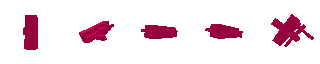

In [33]:
anchors0 = obj_x[0, 0]
anchors0 = list(map(to_pil_img, anchors0))
collage(anchors0, 1, 5)

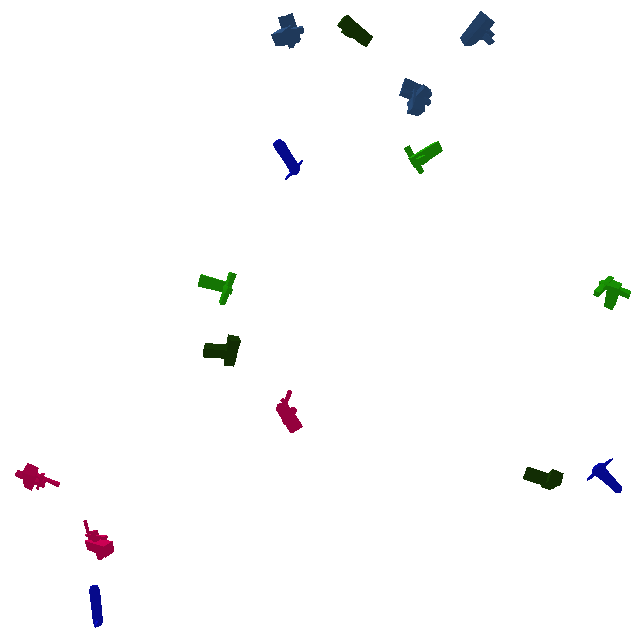

In [34]:
scene0 = to_pil_img(scene_x[0])
scene0

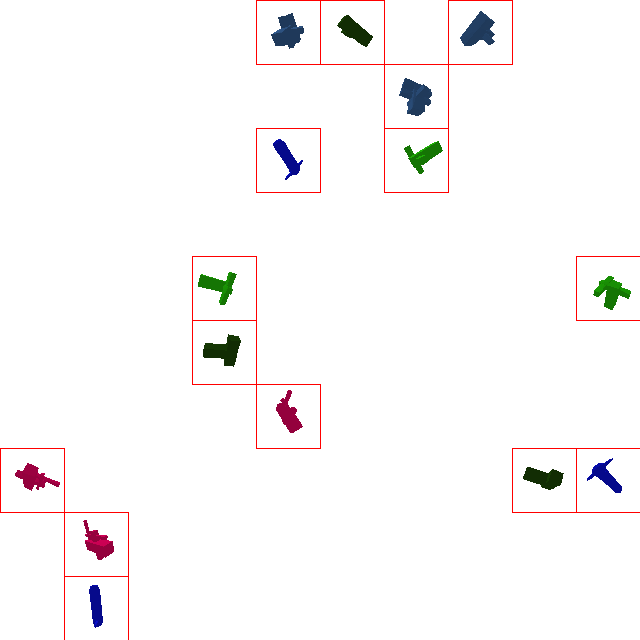

In [35]:
highlight(scene0, y_pred[0])